In [136]:
import xarray as xr
from utils import *
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.gaussian_process.kernels import RationalQuadratic


In [137]:
# # Request an additional 10 cores of power for processing from the server
# client = get_cluster("UCSB0021", cores = 40)
# # apply peer2peer network communication across multiple devices
# client.cluster

In [138]:
def read_n_wrangle(param, var):
    params = param_wrangling()
    filepath = os.path.join("saves", f"{var}.nc")
    global param_name, var_name
    param_name = param
    var_name = var
    var_da = subset_var_cluster(var)
    var_avg = wrangle_var_cluster(var_da)
    return params, var_avg, param

#read_n_wrangle("LEAFN", "TSA")
params, var, param = read_n_wrangle("FFF","FSNO")

In [139]:
def train_emulator(params, var):
    # Splitting the data
    X_train, X_test, y_train, y_test = train_test_split(params, var, test_size=0.2, random_state=42)

    # Instantiate the model and tune nothing in the beginning
    kernel = RationalQuadratic(length_scale=1, alpha=1, alpha_bounds=(1e-4, 1e10))
    gp_model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42, normalize_y=True)
    return gp_model, X_train, X_test, y_train, y_test

In [140]:
gp_model, X_train, X_test, y_train, y_test = train_emulator(params, var)

In [141]:
from sklearn.metrics import mean_absolute_error

def cross_val_plot(model, X_train, y_train):
    # Perform 5-fold cross-validation predictions
    cross_val_predict(model, X_train, y_train, cv=5)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Calculate mean absolute error
    mae = mean_absolute_error(y_test, y_pred)
    
    # Plotting
    plt.figure(figsize=(10, 6))
    
    # Scatter plot of predicted vs. measured values
    plt.scatter(y_test, y_pred, edgecolors=(0, 0, 0))
    
    # Plot the perfect fit line
    plt.plot([var.min(), var.max()], [var.min(), var.max()], 'k--', lw=4)
    
    # Annotate mean absolute error value
    plt.annotate('Perfect Gaussian regressor would produce all points exactly on this dotted line', xy=(0.5, 0.9), xycoords='axes fraction', ha='center', fontsize=12, color='red')
    plt.annotate(f'Mean Absolute Error: {mae:.2f}', xy=(0.5, 0.85), xycoords='axes fraction', ha='center', fontsize=12, color='red')
    
    plt.xlabel('Measured')
    plt.ylabel('Predicted')
    plt.title('Cross-Validation Plot (Model performance for your chosen variable)')
    plt.show()

/glade/u/home/sbhattarai/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/glade/u/home/sbhattarai/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:434: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/u/home/sbhattarai/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    ht

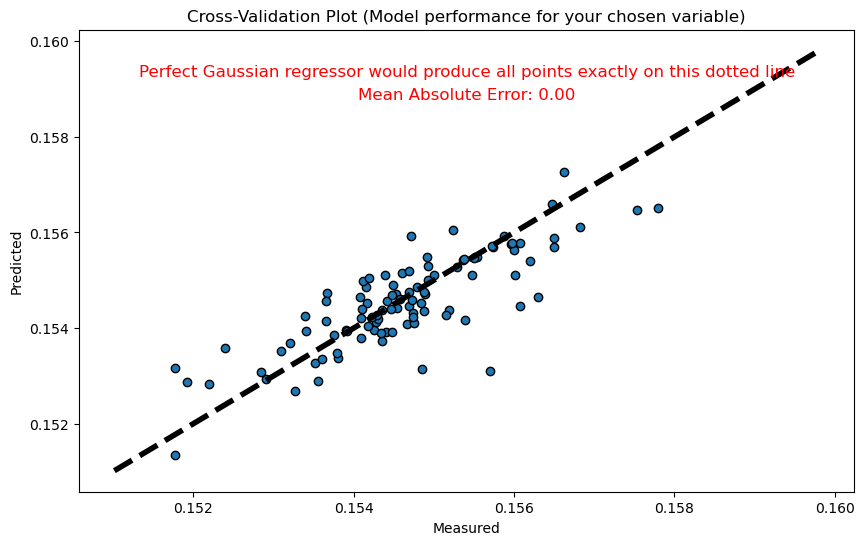

In [142]:
cross_val_plot(gp_model, X_train, y_train)

In [143]:
def create_parameter_names_dict():
    data = {
        key.upper(): value for key, value in {
            'FUN_fracfixers': 0, 'KCN': 1, 'a_fix': 2, 'crit_dayl': 3, 'd_max': 4, 'fff': 5,
            'froot_leaf': 6, 'fstor2tran': 7, 'grperc': 8, 'jmaxb0': 9, 'jmaxb1': 10, 'kcha': 11,
            'kmax': 12, 'krmax': 13, 'leaf_long': 14, 'leafcn': 15, 'lmr_intercept_atkin': 16,
            'lmrha': 17, 'lmrhd': 18, 'medlynintercept': 19, 'medlynslope': 20, 'nstem': 21,
            'psi50': 22, 'q10_mr': 23, 'slatop': 24, 'soilpsi_off': 25, 'stem_leaf': 26,
            'sucsat_sf': 27, 'theta_cj': 28, 'tpu25ratio': 29, 'tpuse_sf': 30, 'wc2wjb0': 31
        }.items()
    }
    return data


In [144]:
param_df = create_parameter_names_dict()

In [145]:
# Define a custom function to generate the Gaussian regression line
def gaussian_regression_line(model):
   #get the index for parameters
    index = param_df.get(param_name)
    
    # Generate x_values with 32 dimensions
    x_values = np.full((10, 32), 0.5)  # Fill array with 0.5
    x_values[:, index] = np.linspace(0, 1, 10)

    # Predict mean and standard deviation of the Gaussian process at each point in x_values
    y_mean, y_std = model.predict(x_values, return_std=True)

    # Plot the mean line
    plt.plot(x_values[:, index], y_mean, color='blue', linestyle='-', label='Gaussian Regression Line')

    # Calculate the z-score for the 99.7% confidence interval
    z_score = norm.ppf(0.99865)  # 99.7th percentile (three standard deviations)

    # Plot the shaded region for the 99.7% confidence interval with three standard deviations
    plt.fill_between(x_values[:, index], y_mean - z_score * y_std, y_mean + z_score * y_std, color='lightblue', alpha=0.3)


    # Plot the z-score value on the plot
    plt.text(0.5, 0.5, f'99.7% CI (z-score: {z_score:.2f})', transform=plt.gca().transAxes, fontsize=10, verticalalignment='bottom')
    plt.xlabel(f'{param_name} values between 0 and 1')
    plt.ylabel(f'{param_name} set to 1, rest all parameters to 0.5')
    plt.title('Actual Training Data vs Gaussian Regression Line with 99.7% Confidence Interval')
    plt.legend()
    plt.show()


In [146]:
def gaussian_regression_line(model):
   #get the index for parameters
    index = param_df.get(param_name)
    
    # Initialize variables to store min and max y values globally
    min_y_value_global = float('inf')
    max_y_value_global = float('-inf')
    
    for param_index in range(32):
        # Generate x_values with 32 dimensions
        x_values = np.full((10, 32), 0.5)  # Fill array with 0.5
        x_values[:, param_index] = np.linspace(0, 1, 10)  # Set the current parameter values to evenly spaced values from 0 to 1

        # Predict mean and standard deviation of the Gaussian process at each point in x_values
        y_mean, y_std = model.predict(x_values, return_std=True)
        
        # Calculate the z-score for the 99.7% confidence interval
        z_score = norm.ppf(0.99865)  # 99.7th percentile (three standard deviations)

        # Calculate y values for the 99.7% confidence interval
        y_lower = y_mean - z_score * y_std
        y_upper = y_mean + z_score * y_std
        
        # Update global min and max y values
        min_y_value_global = min(min_y_value_global, np.min(y_lower))
        max_y_value_global = max(max_y_value_global, np.max(y_upper))
        
    # Generate x_values with 32 dimensions
    x_values = np.full((10, 32), 0.5)  # Fill array with 0.5
    x_values[:, index] = np.linspace(0, 1, 10)

    # Predict mean and standard deviation of the Gaussian process at each point in x_values
    y_mean, y_std = model.predict(x_values, return_std=True)

    # Plot the mean line
    plt.plot(x_values[:, index], y_mean, color='blue', linestyle='-', label='Gaussian Regression Line')

    # Calculate the z-score for the 99.7% confidence interval
    z_score = norm.ppf(0.99865)  # 99.7th percentile (three standard deviations)

    # Plot the shaded region for the 99.7% confidence interval with three standard deviations
    plt.fill_between(x_values[:, index], y_mean - z_score * y_std, y_mean + z_score * y_std, color='lightblue', alpha=0.3)


    # Plot the z-score value on the plot
    plt.text(0.5, 0.5, f'99.7% CI (z-score: {z_score:.2f})', transform=plt.gca().transAxes, fontsize=10, verticalalignment='bottom')
    plt.xlabel(f'{param_name} values between 0 and 1')
    plt.ylabel(f'{param_name} set to 1, rest all parameters to 0.5')
    plt.title('Actual Training Data vs Gaussian Regression Line with 99.7% Confidence Interval')
    plt.ylim(min_y_value_global, max_y_value_global)
    plt.legend()
    plt.show()


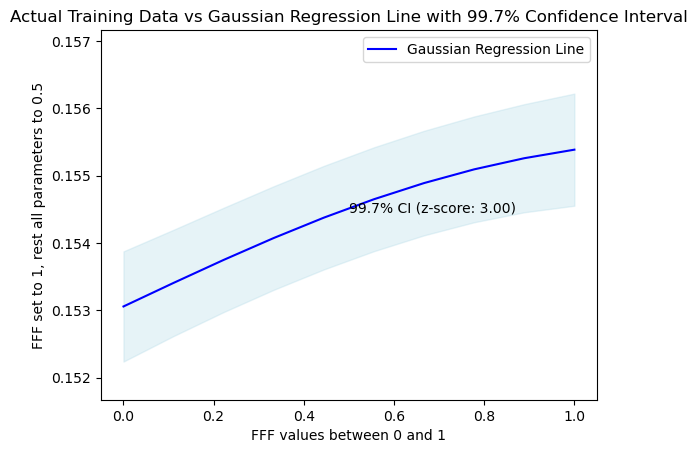

In [147]:
gaussian_regression_line(gp_model)

In [148]:
#Fast plot
def fast_sensitivity_test(model):
    # Define a custom function to generate the Gaussian regression line for each parameter
    def gaussian_regression_lines(model):
        fourier_amplitudes = []  # List to store Fourier amplitudes for each parameter
        
        for param_index in range(32):
            # Generate x_values with 32 dimensions
            x_values = np.full((10, 32), 0.5)  # Fill array with 0.5
            x_values[:, param_index] = np.linspace(0, 1, 10)  # Set the current parameter values to evenly spaced values from 0 to 1

            # Predict mean and standard deviation of the Gaussian process at each point in x_values
            y_mean, _ = model.predict(x_values, return_std=True)

            # Compute Fourier transform of the model output
            y_fft = fft(y_mean)

            # Compute amplitude of each frequency component
            amplitude = np.abs(y_fft)

            # Store the amplitude corresponding to the first non-zero frequency (excluding DC component)
            fourier_amplitudes.append(amplitude[1])

        return fourier_amplitudes

    # Calculate Fourier amplitudes
    fourier_amplitudes = gaussian_regression_lines(gp_model)

    # Sort parameters based on Fourier amplitudes in descending order
    sorted_indices = np.argsort(fourier_amplitudes)
    sorted_fourier_amplitudes = np.array(fourier_amplitudes)[sorted_indices]
    
    # Swapping keys and values using a dictionary comprehension
    swapped_param_keys = {v: k for k, v in create_parameter_names_dict().items()}

    # Extract parameter names corresponding to sorted indices from lookup table
    sorted_parameter_names = [swapped_param_keys[index] for index in sorted_indices]

    # Plot horizontal bar chart
    plt.figure(figsize=(16, 8))
    plt.barh(range(len(sorted_fourier_amplitudes)), sorted_fourier_amplitudes, color='#50c878')
    plt.ylabel('')
    plt.xlabel('Fourier Amplitude')
    plt.title(f'Fourier amplitude sensitivity test(FAST) for {var_name}')
    plt.yticks(range(len(sorted_fourier_amplitudes)), sorted_parameter_names)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.gca().set_aspect('auto', adjustable='box')
    plt.show()


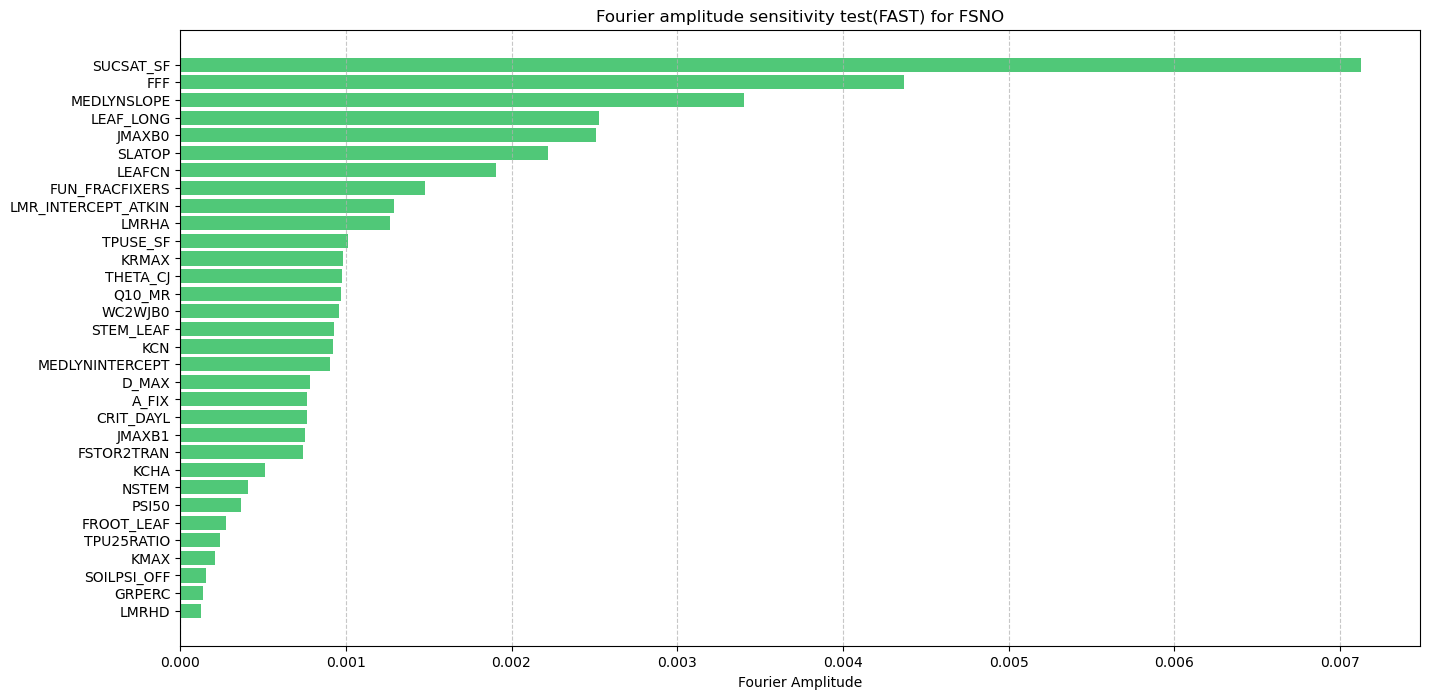

In [149]:
fast_sensitivity_test(gp_model)